In [ ]:
# Set columns in display
# pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns') # Reset options to default

# Set rows in display
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows') # Reset options to default

# Load Util File with TARE Model Functions

In [ ]:
import os

# Measure Package 0: Baseline
menu_mp = 0
input_mp = 'baseline'

# Get the current working directory of the project
project_root = os.path.abspath(os.getcwd())
print(f"Project root directory: {project_root}")

# Relative path to the file from the project root
relative_path = r"tare_model_functions_v3.ipynb"

# Construct the absolute path to the file
file_path = os.path.join(project_root, relative_path)
print(f"File path: {file_path}")

# Run the notebook and import variables
if os.path.exists(relative_path):
    get_ipython().run_line_magic('run', f'-i "{relative_path}"')
    print("Loaded All TARE Model Functions")
else:
    print(f"File not found: {relative_path}")

In [ ]:
# Storing Result Outputs in output_results folder
relative_path = r"output_results"
output_folder_path = os.path.join(project_root, relative_path)
print(f"Result outputs will be exported here: {output_folder_path}")

# Baseline: 

## Simulate Residential Energy Consumption
- Filter EUSS Data: Only occupied units and Single Family Homes



In [ ]:
# The ``inline`` flag will use the appropriate backend to make figures appear inline in the notebook.  
%matplotlib inline

import pandas as pd
import numpy as np

# `plt` is an alias for the `matplotlib.pyplot` module
import matplotlib.pyplot as plt

# import seaborn library (wrapper of matplotlib)
import seaborn as sns
sns.set(style="darkgrid")

# For regex, import re
import re

from datetime import datetime

# Get the current datetime
# Start the timer
start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Welcome to the Trade-off Analysis of residential Retrofits for energy Equity Tool (TARE Model)
Let's start by reading the data from the NREL EUSS Database.

Make sure that the zipped folders stay organized as they are once unzipped.
If changes are made to the file path, then the program will not run properly.
-------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------
BASELINE (Measure Package 0)
-------------------------------------------------------------------------------------------------------
""")

# Measure Package 0: Baseline
menu_mp = 0
input_mp = 'baseline'

filename = "baseline_metadata_and_annual_results.csv"
relative_path = os.path.join(r"euss_data\resstock_amy2018_release_1.1\state", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")

print("""
-------------------------------------------------------------------------------------------------------
Data Filters: Only occupied units and Single Family Homes
-------------------------------------------------------------------------------------------------------
""")

# Fix DtypeWarning error in columns:
# 'in.neighbors', 'in.geometry_stories_low_rise', 'in.iso_rto_region', 'in.pv_orientation', 'in.pv_system_size'
columns_to_string = {11: str, 61: str, 121: str, 103: str, 128: str, 129: str}
df_euss_am_baseline = pd.read_csv(file_path, dtype=columns_to_string)
occupancy_filter = df_euss_am_baseline['in.vacancy_status'] == 'Occupied'
df_euss_am_baseline = df_euss_am_baseline.loc[occupancy_filter]

# Filter for single family home building type
house_type_list = ['Single-Family Attached', 'Single-Family Detached']
house_type_filter = df_euss_am_baseline['in.geometry_building_type_recs'].isin(house_type_list)
df_euss_am_baseline = df_euss_am_baseline.loc[house_type_filter]
# df_euss_am_baseline

In [ ]:
# # Make a copy of the dataframe
# df_euss_am_baseline = df_euss_am_baseline.copy()

# Choose between national or sub-national level analysis
menu_state = get_menu_choice(menu_prompt, {'N', 'Y'})   # This code is only run in baseline

# National Level 
if menu_state == 'N':
    print("You chose to analyze all of the United States.")
    input_state = 'National'

# Filter down to state or city
else:
    input_state = get_state_choice(df_euss_am_baseline)
    print(f"You chose to filter for: {input_state}")
    state_filter = df_euss_am_baseline['in.state'].eq(input_state)
    df_euss_am_baseline = df_euss_am_baseline.loc[state_filter]

    print(city_prompt)
    print(df_euss_am_baseline['in.city'].value_counts())

    menu_city = get_menu_choice(city_menu_prompt, {'N', 'Y'})

    # Filter for the entire selected state
    if menu_city == 'N':
        print(f"You chose to analyze all of state: {input_state}")
        
    # Filter to a city within the selected state
    else:
        input_cityFilter = get_city_choice(df_euss_am_baseline, input_state)
        print(f"You chose to filter for: {input_state}, {input_cityFilter}")
        city_filter = df_euss_am_baseline['in.city'].eq(f"{input_state}, {input_cityFilter}")
        df_euss_am_baseline = df_euss_am_baseline.loc[city_filter]

# Display the filtered dataframe
df_euss_am_baseline

## Baseline Energy Consumption
### Factors to Project Future Energy Consumption Using EIA Heating Degree Day (HDD) Forecasted Data

In [ ]:
# Factors for 2022 to 2050
filename = 'aeo_projections_2022_2050.xlsx'
relative_path = os.path.join(r"projections", filename)
file_path = os.path.join(project_root, relative_path)
df_hdd_projection_factors = pd.read_excel(io=file_path, sheet_name='hdd_factors_2022_2050')

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")

# Convert the factors dataframe into a lookup dictionary
hdd_factor_lookup = df_hdd_projection_factors.set_index(['census_division']).to_dict('index')
hdd_factor_lookup

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Baseline Consumption:
-------------------------------------------------------------------------------------------------------
""")

# df_baseline_enduse(df_baseline, df_enduse, category, fuel_filter='Yes', tech_filter='Yes')
df_euss_am_baseline_home = df_enduse_refactored(df_baseline = df_euss_am_baseline,
                                                fuel_filter = 'Yes',
                                                tech_filter = 'Yes')

# Project Future Energy Consumption
df_euss_am_baseline_home = project_future_consumption(df=df_euss_am_baseline_home, hdd_factor_lookup=hdd_factor_lookup, menu_mp=menu_mp)
df_euss_am_baseline_home

## Factors to Project Future Energy Consumption Using EIA Heating Degree Day (HDD) Forecasted Data

## Public Perspective: Monetized Marginal Damages from Emissions

### Step 1: Calculate emissions factors for different fuel sources

### Marginal Emissions Factors
#### Electricity
- STATE Regional Aggregation is what is used in the Parth Analysis 
- "Marginal Emissions Factors for Electricity"
- Factor Type: Marginal
- Calculation Method: Regression
- Metric: Emissions [kg/MWh]")
- Predictor: Year")
- Pollutants: SO2, NOx, PM2.5, CO2")
#### Fossil Fuels
- NOx, SO2, CO2: 
    - RESNET Table 7.1.2 Emissions Factors for Household Combustion Fuels
    - Source: https://www.resnet.us/wp-content/uploads/ANSIRESNETICC301-2022_resnetpblshd.pdf
    - All factors are in units of lb/Mbtu so energy consumption in kWh need to be converted to kWh 
    - (1 lb / Mbtu) * (1 Mbtu / 1x10^6 Btu) * (3412 Btu / 1 kWh)
- PM2.5: 
    - A National Methodology and Emission Inventory for Residential Fuel Combustion
    - Source: https://www3.epa.gov/ttnchie1/conference/ei12/area/haneke.pdf

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Public Perspective: Monetized Marginal Damages from Emissions
-------------------------------------------------------------------------------------------------------
Step 1: Calculate emissions factors for different fuel sources
- Electricity
- Natural Gas
- Fuel Oil 
- Propane
-------------------------------------------------------------------------------------------------------
""")

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Calculate Emissions Factors: ELECTRICITY
-------------------------------------------------------------------------------------------------------
Electricity Marginal Emissions Factors:
- STATE Regional Aggregation is what is used in the Parth Analysis 
- "Marginal Emissions Factors for Electricity"
- Factor Type: Marginal
- Calculation Method: Regression
- Metric: Emissions [kg/MWh]
- Predictor: Year")
- Pollutants: SO2, NOx, PM2.5, CO2
-------------------------------------------------------------------------------------------------------
""")
filename = 'Generation-MARREG-EMIT-state-byYear.csv'
relative_path = os.path.join(r"margEmis_electricity", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")
print("\n")

df_margEmissions = pd.read_csv(file_path, index_col=0)

# Convert from kg/MWh to lb/kWh
# Obtain value from the CSV file and convert to lbs pollutant per kWh 
df_margEmis_electricity = pd.DataFrame({
    'state': df_margEmissions['region'],
    'fuel_type': 'electricity',
    'pollutant': df_margEmissions['pollutant'],
    'value': df_margEmissions['factor'] * (2.20462/1) * (1/1000),
    'unit': '[lb/kWh]'
})
df_margEmis_electricity

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Calculate Emissions Factors: FOSSIL FUELS
-------------------------------------------------------------------------------------------------------
Fossil Fuels (Natural Gas, Fuel Oil, Propane):
- NOx, SO2, CO2: 
    - RESNET Table 7.1.2 Emissions Factors for Household Combustion Fuels
    - Source: https://www.resnet.us/wp-content/uploads/ANSIRESNETICC301-2022_resnetpblshd.pdf
    - All factors are in units of lb/Mbtu so energy consumption in kWh need to be converted to kWh 
    - (1 lb / Mbtu) * (1 Mbtu / 1x10^6 Btu) * (3412 Btu / 1 kWh)
- PM2.5: 
    - A National Methodology and Emission Inventory for Residential Fuel Combustion
    - Source: https://www3.epa.gov/ttnchie1/conference/ei12/area/haneke.pdf
-------------------------------------------------------------------------------------------------------
""")

fuelOil_factors = calculate_fossilFuel_emission_factor("fuelOil", 0.0015, 0.1300, 0.83, 161.0, 1000, 138500)
naturalGas_factors = calculate_fossilFuel_emission_factor("naturalGas", 0.0006, 0.0922, 1.9, 117.6, 1000000, 1039)
propane_factors = calculate_fossilFuel_emission_factor("propane", 0.0002, 0.1421, 0.17, 136.6, 1000, 91452)

all_factors = {**fuelOil_factors, **naturalGas_factors, **propane_factors}

df_margEmis_factors = pd.DataFrame.from_dict(all_factors, orient="index", columns=["value"])
df_margEmis_factors.reset_index(inplace=True)
df_margEmis_factors.columns = ["pollutant", "value"]
df_margEmis_factors[["fuel_type", "pollutant"]] = df_margEmis_factors["pollutant"].str.split("_", expand=True)
df_margEmis_factors["unit"] = "[lb/kWh]"

# Add the 'state' column and assign 'National' to every row
df_margEmis_factors = df_margEmis_factors.assign(state='National')

df_margEmis_factors = df_margEmis_factors[["state", "fuel_type", "pollutant", "value", "unit"]]
df_margEmis_factors

### Step 2: Adjust Natural Gas & Electricity Emissions Factors for Natural Gas Leakage

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Step 2: Adjust Natural Gas & Electricity Emissions Factors for Natural Gas Leakage
-------------------------------------------------------------------------------------------------------
Natural Gas (Deetjen et al.): 
"To account for the natural gas infrastructure's leakage of the greenhouse gas methane, 
we estimate the amount of methane leaked per therm of natural gas consumed for heating and 
convert to CO2-equivalent emissions via the GWP of methane. We assume that for every therm of 
natural gas consumed for heating, 0.023 therms of methane escape to the atmosphere [28]. 
Using the energy density of natural gas, we convert from therms to kilograms and multiply 
by 28—the GWP of methane [29]—to calculate a rate of 1.27 kg CO2-equivalent per therm of 
consumed natural gas."

Electricity NERC Regions (Deetjen et al): 
"To account for the natural gas infrastructure's leakage of the greenhouse gas methane, 
we estimate the amount of methane leaked per MWh of electricity generation in each NERC 
region and convert to CO2-equivalent emissions via the global warming potential (GWP) of methane. 
For example, we find that in 2017, the states comprising the western region (WECC) of 
the US electric grid consumed 1.45 million MMcf of natural gas in the power sector [27]. 
We assume that for every MMcf of consumed natural gas, 0.023 MMcf of methane is leaked into 
the atmosphere [28]. By multiplying that leakage rate by the 1.45 million MMcf of consumed 
natural gas, converting to tonnes, and multiplying by a GWP of 28 [29], we estimate 
that the 2017 WECC power sector contributed to methane leakage amounting to 18.6 Mt CO2-equivalent.
By dividing this 18.6 Mt by the 724 TWh of the WECC states' generated electricity [27], we 
calculate a methane leakage rate factor of 25.7 kg MWh−1. In the same manner, we calculate the 
methane leakage rate factors for the other NERC regions. We use the 100 years GWP value of 28 
for methane. Although there have been proposals to use 20 years GWP values, recent research 
shows that the benefits of this alternative 20 years time from are overstated [30]."
-------------------------------------------------------------------------------------------------------
""")
filename = 'natural_gas_leakage_rate.csv'
relative_path = os.path.join(r"margEmis_electricity", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")
print("\n")

df_naturalGas_leakage_rate = pd.read_csv(file_path)

state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia': 'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Map full state names to abbreviations
df_naturalGas_leakage_rate['state'] = df_naturalGas_leakage_rate['state_name'].map(state_abbreviations)

# thousand Mcf * (0.023 Mcf leak/1 Mcf) * (19.3 tonnes/1000 Mcf) * (1000 kg/1 tonne) * (2.205 lb/1 kg)) / (thousand MWh * (1000 MWh/thousand MWh)) 
df_naturalGas_leakage_rate['naturalGas_leakage_lbCH4_perMWh'] = (df_naturalGas_leakage_rate['naturalGas_electricity_generation'] * (0.023/1) * (19.3/1) * (1000/1) * (2.205/1)) / (df_naturalGas_leakage_rate['net_generation'] * (1000/1)) 

# (lb CH4/MWh) * (28 lb CO2e/1 lb CH4)
df_naturalGas_leakage_rate['naturalGas_leakage_lbCO2e_perMWh'] = df_naturalGas_leakage_rate['naturalGas_leakage_lbCH4_perMWh'] * (28/1)

# (lb CO2e/MWh) * (1 MWh / 1000 kWh)
df_naturalGas_leakage_rate['naturalGas_leakage_lbCO2e_perkWh'] = df_naturalGas_leakage_rate['naturalGas_leakage_lbCO2e_perMWh'] * (1/1000)
df_naturalGas_leakage_rate

In [ ]:
# NATURAL GAS LEAKAGE: NATURAL GAS USED IN ELECTRICITY GENERATION
if 'naturalGas_leakage_lbCO2e_perkWh' in df_margEmis_electricity.columns:
    df_margEmis_electricity.drop(columns=['naturalGas_leakage_lbCO2e_perkWh'], inplace=True)

df_margEmis_electricity = df_margEmis_electricity.merge(
    df_naturalGas_leakage_rate[['state', 'naturalGas_leakage_lbCO2e_perkWh']],
    how='left',  # Use a left join to keep all rows from df_margEmis_electricity
    on=['state']  # Merge on the 'state' column
)
# Set 'naturalGas_leakage_lbCO2e_perkWh' to zero where 'pollutant' is not 'co2'
df_margEmis_electricity.loc[df_margEmis_electricity['pollutant'] != 'co2', 'naturalGas_leakage_lbCO2e_perkWh'] = 0.0

# Calculate adjusted marginal emissions factore with natural gas fugitive emissions
df_margEmis_electricity['margEmis_factor_adjusted'] = df_margEmis_electricity['value'] + df_margEmis_electricity['naturalGas_leakage_lbCO2e_perkWh'] 

# Create a factor to multiply marginal damages by
df_margEmis_electricity['naturalGas_leakage_factor'] = df_margEmis_electricity['margEmis_factor_adjusted'] / df_margEmis_electricity['value']

# Reorder columns
df_margEmis_electricity = df_margEmis_electricity[['state', 'fuel_type', 'pollutant', 'value', 'unit', 'naturalGas_leakage_lbCO2e_perkWh', 'margEmis_factor_adjusted', 'naturalGas_leakage_factor']]
df_margEmis_electricity

In [ ]:
# NATURAL GAS LEAKAGE: NATURAL GAS INFRASTRUCTURE
# leakage rate for natural gas infrastructure
# 1 Therm = 29.30 kWh --> 1.27 kg CO2e/therm * (1 therm/29.30 kWh) = 0.043 kg CO2e/kWh = 0.095 lb CO2e/kWh
df_margEmis_factors['naturalGas_leakage_lbCO2e_perkWh'] = 0.095

# Set 'naturalGas_leakage_lbCO2e_perkWh' to zero where 'pollutant' is not 'co2'
df_margEmis_factors.loc[df_margEmis_factors['pollutant'] != 'co2', 'naturalGas_leakage_lbCO2e_perkWh'] = 0.0

# Set 'naturalGas_leakage_lbCO2e_perkWh' to zero where 'fuel_type' is not 'naturalGas'
df_margEmis_factors.loc[df_margEmis_factors['fuel_type'] != 'naturalGas', 'naturalGas_leakage_lbCO2e_perkWh'] = 0.0

# Calculate adjusted marginal emissions factor with natural gas fugitive emissions
df_margEmis_factors['margEmis_factor_adjusted'] = df_margEmis_factors['value'] + df_margEmis_factors['naturalGas_leakage_lbCO2e_perkWh'] 

# Create a factor to multiply marginal damages by
df_margEmis_factors['naturalGas_leakage_factor'] = df_margEmis_factors['margEmis_factor_adjusted'] / df_margEmis_factors['value']

# Reorder columns
df_margEmis_factors = df_margEmis_factors[['state', 'fuel_type', 'pollutant', 'value', 'unit', 'naturalGas_leakage_lbCO2e_perkWh', 'margEmis_factor_adjusted', 'naturalGas_leakage_factor']]
df_margEmis_factors

In [ ]:
# Append df_margEmissions_electricity to df_margEmis_factors
# This produces a dataframe of marginal emissions rates for various fuel types
df_margEmis_factors = pd.concat([df_margEmis_factors, df_margEmis_electricity], ignore_index=True)
df_margEmis_factors

### Step 3: Quantify monitized damages using EASIUR Marginal Social Cost Factors
#### THE STEPS BELOW SUMMARIZE WHAT WAS DONE TO OBTAIN ALL NATIONAL EASIUR VALUES INCLUDED ON GITHUB
- Obtain all of the dwelling unit latitude and longitude values from the metadata columns
- Make a new dataframe of just the longitude and latitude values 
    - Make sure that the order is (longitude, latitude)
    - Do not include the index or column name when exporting 
- Export the CSV
- **Upload csv to EASIUR Website:**
    - Website: https://barney.ce.cmu.edu/~jinhyok/easiur/online/
    - See inputs in respective sections
- Download the file and put it in the 'easiur_batchConversion_download' folder
- Copy and paste the name of the file EASIUR generated when prompted
- Copy and paste the name of the filepath for the 'easiur_batchConversion_download' folder when prompted
- Match up the longitude and latitudes for each dwelling unit with the selected damages

### Fossil Fuels: EASIUR Marginal Damage (Social Cost) Factors Info
- Factor Type: Marginal Social Cost
- Calculation Method: Regression
- Metric: Marginal Social Cost [USD per metric ton]
- Dollar Year: 2010
- Income Year: 2022
- Population Year: 2022
- Aggregation: Longitude, and Latitude Coordinates
- Pollutants: Primary PM2.5, Sulfur Dioxide (SO2), Nitrogen Oxides (NOx), Ammonia (NH3)
- Elevation (Ground, 150m, 300m) and Seasons (Winter, Spring, Summer, Fall)

In [ ]:
# Create a dataframe containing just the longitude and Latitude
df_EASIUR_batchConversion = pd.DataFrame({
    'Longitude':df_euss_am_baseline['in.weather_file_longitude'],
    'Latitude':df_euss_am_baseline['in.weather_file_latitude'],
})

# Drop duplicate rows based on 'Longitude' and 'Latitude' columns
df_EASIUR_batchConversion.drop_duplicates(subset=['Longitude', 'Latitude'], keep='first', inplace=True)

# Create a location ID for the name of the batch conversion file
while True:
    if menu_state == 'N':
        location_id = 'National'
        print("You chose to analyze all of the United States.")
        break
    elif menu_state == 'Y':
        if menu_city == 'N':
            try:
                location_id = str(input_state)
                print(f"Location ID is: {location_id}")
                break
            except ValueError:
                print("Invalid input for state!")
        elif menu_city == 'Y':
            try:
                location_id = input_cityFilter.replace(', ', '_').strip()
                print(f"Location ID is: {location_id}")
                break
            except AttributeError:
                print("Invalid input for city filter!")
        else:
            print("Incorrect state or city filter assignment!")
    else:
        print("Invalid data location. Check your inputs at the beginning of this notebook!")

# Updated GitHub code has EASIUR file with all unique latitude, longitude coordinates in the US
filename = 'easiur_National2024-06-1421-22.csv'
relative_path = os.path.join(r"margDamages_EASIUR\easiur_batchConversion_download", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")
print("\n")

df_margSocialCosts = pd.read_csv(file_path)

# Convert from kg/MWh to lb/kWh
# Obtain value from the CSV file and convert to lbs pollutant per kWh 

# Define df_margSocialCosts_EASIUR DataFrame first
df_margSocialCosts_EASIUR = pd.DataFrame({
    'Longitude': df_margSocialCosts['Longitude'],
    'Latitude': df_margSocialCosts['Latitude']
})
df_margSocialCosts_EASIUR

### Step 4: Inflate Marginal Social Cost (Damage) Factors using BLS CPI for All Urban Consumers (CPI-U)
- Series Id:	CUUR0000SA0
- Not Seasonally Adjusted
- Series Title:	All items in U.S. city average, all urban consumers, not seasonally adjusted
- Area:	U.S. city average
- Item:	All items
- Base Period:	1982-84=100

### Use the updated Social Cost of Carbon (190 USD-2020/ton CO2) and inflate to USD-2022
- EPA Median for 2% near term discount rate and most commonly mentioned value is 190 USD-2020 using the GIVE model.
- 190 USD-2020 has some inconsistency with the VSL being used. An old study and 2008 VSL is noted
- 190 USD value and inflate to USD 2022 because there is a clear source and ease of replicability.

### Adjustment for VSL
- EASIUR uses a VSL of 8.8M USD-2010 
- New EPA VSL is 11.3M USD-2021
- INFLATE TO $USD-2022

### ALL DOLLAR VALUES ARE NOW IN USD2022, PREVIOUSLY USED $USD-2021

In [ ]:
# Load the BLS Inflation Data
filename = 'bls_cpiu_2005-2023.xlsx'
relative_path = os.path.join(r"inflation_data", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")

# Create a pandas dataframe
df_bls_cpiu = pd.read_excel(file_path, sheet_name='bls_cpiu')

df_bls_cpiu = pd.DataFrame({
    'year': df_bls_cpiu['Year'],
    'cpiu_annual': df_bls_cpiu['Annual']
})

# Obtain the Annual CPIU values for the years of interest
bls_cpi_annual_2008 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2008)].item()
bls_cpi_annual_2010 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2010)].item()
bls_cpi_annual_2013 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2013)].item()
bls_cpi_annual_2018 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2018)].item()
bls_cpi_annual_2019 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2019)].item()
bls_cpi_annual_2020 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2020)].item()
bls_cpi_annual_2021 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2021)].item()
bls_cpi_annual_2022 = df_bls_cpiu['cpiu_annual'].loc[(df_bls_cpiu['year'] == 2022)].item()

# Precompute constant values
cpi_ratio_2022_2022 = bls_cpi_annual_2022 / bls_cpi_annual_2022
cpi_ratio_2022_2021 = bls_cpi_annual_2022 / bls_cpi_annual_2021  # For EPA VSL (11.3M USD-2021)
cpi_ratio_2022_2020 = bls_cpi_annual_2022 / bls_cpi_annual_2020  # For SCC
cpi_ratio_2022_2019 = bls_cpi_annual_2022 / bls_cpi_annual_2019 
cpi_ratio_2022_2018 = bls_cpi_annual_2022 / bls_cpi_annual_2018 
cpi_ratio_2022_2013 = bls_cpi_annual_2022 / bls_cpi_annual_2013
cpi_ratio_2022_2010 = bls_cpi_annual_2022 / bls_cpi_annual_2010
cpi_ratio_2022_2008 = bls_cpi_annual_2022 / bls_cpi_annual_2008  # For EPA VSL and SCC

# 2021 US EPA VSL is $11.3M in 2021 
# INFLATE TO USD2022, PREVIOUSLY USD2021
df_margSocialCosts_EASIUR['current_VSL_USD2022'] = 11.3 * cpi_ratio_2022_2021

# Easiur uses a VSL of $8.8 M USD2010
# Inflate to 2022 $USD
# PREVIOUSLY USD2021
df_margSocialCosts_EASIUR['easiur_VSL_USD2022'] = 8.8 * cpi_ratio_2022_2010

# Use df_margSocialCosts_EASIUR in the calculation of other columns
# Also adjust the VSL
df_margSocialCosts_EASIUR['margSocialCosts_pm25'] = round((df_margSocialCosts['PM25 Annual Ground'] * (1/2204.6) * (df_margSocialCosts_EASIUR['current_VSL_USD2022']/df_margSocialCosts_EASIUR['easiur_VSL_USD2022'])), 2)
df_margSocialCosts_EASIUR['margSocialCosts_so2'] = round((df_margSocialCosts['SO2 Annual Ground'] * (1/2204.6) * (df_margSocialCosts_EASIUR['current_VSL_USD2022']/df_margSocialCosts_EASIUR['easiur_VSL_USD2022'])), 2)
df_margSocialCosts_EASIUR['margSocialCosts_nox'] = round((df_margSocialCosts['NOX Annual Ground'] * (1/2204.6) * (df_margSocialCosts_EASIUR['current_VSL_USD2022']/df_margSocialCosts_EASIUR['easiur_VSL_USD2022'])), 2)

# Note that SCC of $190 USD-2020 has some inconsistency with the VSL being used. An old study and 2008 VSL is noted
# We use the $190 USD value and inflate to USD 2022 because there is a clear source and ease of replicability.
# PREVIOUSLY USED USD2021
df_margSocialCosts_EASIUR['margSocialCosts_co2'] = round((190 * cpi_ratio_2022_2020 * (1/2204.6)), 2)
df_margSocialCosts_EASIUR['unit'] = '[$USD2022/lb]'
df_margSocialCosts_EASIUR

## Electricity CEDM-EASIUR Marginal Damages: Current and Decarbonizing Grid
- Factor Type: Marginal
- Calculation Method: Regression
- Metric: Marginal Damages EASIUR [USD per MWh or kWh]
- Year: 2018
- Regional Aggregation: eGRID subregion (all regions)
- Pollutants: SO2, NOx, PM2.5 CO2

SCC Adjustment: We use the EPA suggested 190 USD-2020 value for the social cost of carbon and inflate to 2022 USD. **PREVIOUSLY USED 2021 USD**

VSL: "We use a value of a statistical life (VSL) of USD 8.8 million (in 2010 dollars) for both our AP2 and EASIUR calculations. EASIUR reports damage intensities in USD/metric ton using this VSL and dollar year."

Bistline et al. 2023 (ERL Paper): 
- ERL Paper: https://iopscience.iop.org/article/10.1088/1748-9326/ad0d3b/meta#erlad0d3bs6
- Data on Zenodo: https://zenodo.org/records/8322973
- Health related emissions reductions from 2021 levels (assumed mostly coal):
    - "In 2035, unabated coal reductions from 2021 levels range from 44%–100% with IRA (84% average) versus 12%–63% in the reference (38% average)."
    - Pre-IRA Scenario: -38% from 2021 levels
    - IRA-Ref Scenario: -84% from 2021 levels
    - IRA-High Scenario: -100% from 2021 levels
- CO2 reductions from 2005 (see image):
    - Pre-IRA Scenario: -53% from 2005 levels
    - IRA-Ref Scenario: -78% from 2005 levels
    - IRA-High Scenario: -87% from 2005 levels

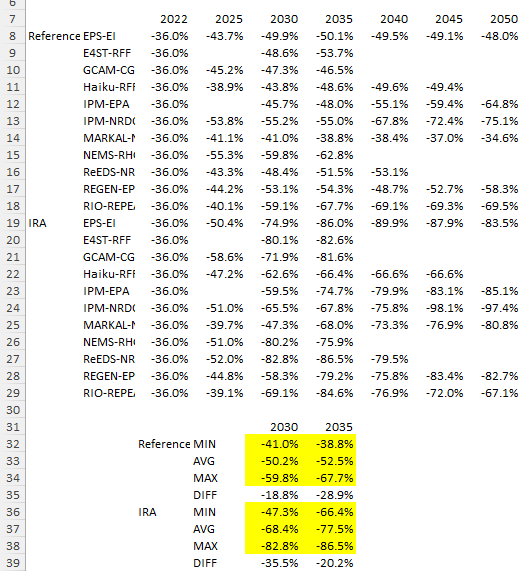

In [ ]:
# For CO2 adjust SCC
# Create an adjustment factor for the new Social Cost of Carbon (SCC)
epa_scc = 190 * cpi_ratio_2022_2020
old_scc = 40 * cpi_ratio_2022_2010
scc_adjustment_factor = epa_scc / old_scc

# For Health-Related Emissions Adjust for different Value of a Statistical Life (VSL) values
# Current VSL is $11.3 M USD2021
# INFLATE TO USD2022, PREVIOUSLY USD2021
current_VSL_USD2022 = 11.3 * cpi_ratio_2022_2021

# Easiur uses a VSL of $8.8 M USD2010
# INFLATE TO USD2022, PREVIOUSLY USD2021
easiur_VSL_USD2022 = 8.8 * (cpi_ratio_2022_2010)

# Calculate VSL adjustment factor
vsl_adjustment_factor = current_VSL_USD2022 / easiur_VSL_USD2022

### Damages from Climate Related Emissions

In [ ]:
# Note only 2006 data available, used in place of 2005
filename = 'Generation-MARREG-DAMEASIUR-egrid-byYear_climate2006.csv'
relative_path = os.path.join(r"margDamages_EASIUR", filename)
file_path = os.path.join(project_root, relative_path)
df_margDamages_climate2006 = pd.read_csv(file_path, index_col=0)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")

In [ ]:
# Note 2018 start year
filename = 'Generation-MARREG-DAMEASIUR-egrid-byYear_climate2018.csv'
relative_path = os.path.join(r"margDamages_EASIUR", filename)
file_path = os.path.join(project_root, relative_path)
df_margDamages_climate2018 = pd.read_csv(file_path, index_col=0)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")

In [ ]:
# Inflate from $USD2010 to $USD2022
# Note only 2006 data available, used in place of 2005
df_margDamages_EASIUR_climate = pd.DataFrame({
    'subregion_eGRID': df_margDamages_climate2006['region'],
    'pollutant': df_margDamages_climate2006['pollutant'],
    'unit': '[$USD2022/kWh]',
    'preIRA_2035_decarb': '53% from 2005',
    'iraRef_2035_decarb': '78% from 2005',
    'iraHigh_2035_decarb': '87% from 2005',
    'margDamages_dollarPerkWh_adjustVSL_ref': (df_margDamages_climate2006['factor'] * (scc_adjustment_factor) * (1/1000)) * (cpi_ratio_2022_2010),
    'margDamages_dollarPerkWh_adjustVSL_2018': (df_margDamages_climate2018['factor'] * (scc_adjustment_factor) * (1/1000)) * (cpi_ratio_2022_2010)
})

# Pre-IRA Scenario: CO2 emissions -53% from 2005 levels
df_margDamages_EASIUR_climate['preIRA_margDamages_decarb_2035'] = df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_ref'] - (df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_ref'] * 0.53)
df_margDamages_EASIUR_climate['preIRA_reduction_margDamages_2035'] = df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_2018'] - df_margDamages_EASIUR_climate['preIRA_margDamages_decarb_2035']
df_margDamages_EASIUR_climate['preIRA_reduction_margDamages_annual'] = df_margDamages_EASIUR_climate['preIRA_reduction_margDamages_2035'] / 17 # Relative to 2018, 

# IRA-Ref Scenario: CO2 emissions -78% from 2005 levels
df_margDamages_EASIUR_climate['iraRef_margDamages_decarb_2035'] = df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_ref'] - (df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_ref'] * 0.78)
df_margDamages_EASIUR_climate['iraRef_reduction_margDamages_2035'] = df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_2018'] - df_margDamages_EASIUR_climate['iraRef_margDamages_decarb_2035']
df_margDamages_EASIUR_climate['iraRef_reduction_margDamages_annual'] = df_margDamages_EASIUR_climate['iraRef_reduction_margDamages_2035'] / 17 # Relative to 2018, 

# IRA-High Scenario: CO2 emissions -87% from 2005 levels
df_margDamages_EASIUR_climate['iraHigh_margDamages_decarb_2035'] = df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_ref'] - (df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_ref'] * 0.87)
df_margDamages_EASIUR_climate['iraHigh_reduction_margDamages_2035'] = df_margDamages_EASIUR_climate['margDamages_dollarPerkWh_adjustVSL_2018'] - df_margDamages_EASIUR_climate['iraHigh_margDamages_decarb_2035']
df_margDamages_EASIUR_climate['iraHigh_reduction_margDamages_annual'] = df_margDamages_EASIUR_climate['iraHigh_reduction_margDamages_2035'] / 17 # Relative to 2018, 

print(df_margDamages_EASIUR_climate)

### Damages from Health Related Emissions

In [ ]:
filename = 'Generation-MARREG-DAMEASIUR-egrid-byYear_health2018.csv'
relative_path = os.path.join(r"margDamages_EASIUR", filename)
file_path = os.path.join(project_root, relative_path)
df_margDamages_health2018 = pd.read_csv(file_path, index_col=0)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")

In [ ]:
# Marginal damages [$/kWh]
# Inflate from 2010 to 2022
# Note only 2018 data available, used in place of 2021
df_margDamages_EASIUR_health = pd.DataFrame({
    'subregion_eGRID': df_margDamages_health2018['region'],
    'pollutant': df_margDamages_health2018['pollutant'],
    'unit': '[$USD2022/kWh]',
    'preIRA_2035_decarb': '38% from 2021',
    'iraRef_2035_decarb': '84% from 2021',
    'iraHigh_2035_decarb': '100% from 2021',   
    'margDamages_dollarPerkWh_adjustVSL_ref': (df_margDamages_health2018['factor'] * (vsl_adjustment_factor) * (1/1000)) * (cpi_ratio_2022_2010),
    'margDamages_dollarPerkWh_adjustVSL_2018': (df_margDamages_health2018['factor'] * (vsl_adjustment_factor) * (1/1000)) * (cpi_ratio_2022_2010)
})

# Pre-IRA Scenario: Health-Related emissions (Unabated Coal) -38% from 2021 levels
df_margDamages_EASIUR_health['preIRA_margDamages_decarb_2035'] = df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_ref'] - (df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_ref'] * 0.38)
df_margDamages_EASIUR_health['preIRA_reduction_margDamages_2035'] = df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_2018'] - df_margDamages_EASIUR_health['preIRA_margDamages_decarb_2035']
df_margDamages_EASIUR_health['preIRA_reduction_margDamages_annual'] = df_margDamages_EASIUR_health['preIRA_reduction_margDamages_2035'] / 14 # Relative to 2021, 

# IRA-Ref Scenario: Health-Related emissions (Unabated Coal) -84% from 2021 levels
df_margDamages_EASIUR_health['iraRef_margDamages_decarb_2035'] = df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_ref'] - (df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_ref'] * 0.84)
df_margDamages_EASIUR_health['iraRef_reduction_margDamages_2035'] = df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_2018'] - df_margDamages_EASIUR_health['iraRef_margDamages_decarb_2035']
df_margDamages_EASIUR_health['iraRef_reduction_margDamages_annual'] = df_margDamages_EASIUR_health['iraRef_reduction_margDamages_2035'] / 14 # Relative to 2021, 

# IRA-High Scenario: Health-Related emissions (Unabated Coal) -100% from 2021 levels
df_margDamages_EASIUR_health['iraHigh_margDamages_decarb_2035'] = df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_ref'] - (df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_ref'] * 1.0)
df_margDamages_EASIUR_health['iraHigh_reduction_margDamages_2035'] = df_margDamages_EASIUR_health['margDamages_dollarPerkWh_adjustVSL_2018'] - df_margDamages_EASIUR_health['iraHigh_margDamages_decarb_2035']
df_margDamages_EASIUR_health['iraHigh_reduction_margDamages_annual'] = df_margDamages_EASIUR_health['iraHigh_reduction_margDamages_2035'] / 14 # Relative to 2021, 

df_margDamages_EASIUR_health

In [ ]:
# Combine them top to bottom
df_margDamages_EASIUR = pd.concat([df_margDamages_EASIUR_climate, df_margDamages_EASIUR_health], ignore_index=True)
print(df_margDamages_EASIUR)

In [ ]:
# Marginal Damages for a Gradually Decarbonizing Grid
df_margDamages_gridDecarb = df_margDamages_EASIUR.copy()

# Assuming df_margDamages_gridDecarb is already a copy of df_margDamages_EASIUR
years = list(range(2018, 2051))
scenario_list = ['preIRA_', 'iraRef_', 'iraHigh_']

# Initialize columns for each scenario and year based on 2018 reference
for scenario in scenario_list:
    for year in years:
        # Define the name of the new column for the current year and scenario
        column_name = f'{scenario}margDamages_dollarPerkWh_adjustVSL_{year}'
        
        if year == 2018:
            # For the base year 2018, use the existing marginal damages as the starting point
            df_margDamages_gridDecarb[column_name] = df_margDamages_gridDecarb['margDamages_dollarPerkWh_adjustVSL_2018']
        else:
            # Initialize other years' columns to None, to be filled in later steps
            df_margDamages_gridDecarb[column_name] = None

# Apply reductions iteratively for each year and scenario
for scenario in scenario_list:
    for year in years:
        # Define the name of the current year's column and the previous year's column
        column_name = f'{scenario}margDamages_dollarPerkWh_adjustVSL_{year}'
        previous_year_column = f'{scenario}margDamages_dollarPerkWh_adjustVSL_{year-1}'

        # Handle reductions for years between 2019 and 2035
        if year > 2018 and year <= 2035:
            # Determine if the pollutant is CO2 (climate-related) for applying early reductions
            is_climate = df_margDamages_gridDecarb['pollutant'] == 'co2'
            
            # Determine if the year is 2022 or later, when health-related reductions begin
            is_health_period = year >= 2022

            # Retrieve the annual reduction factor for the current scenario
            reduction = df_margDamages_gridDecarb[f'{scenario}reduction_margDamages_annual']
            
            # Apply the reduction only if it's relevant:
            # - For CO2 (climate) reductions start from 2019 onwards.
            # - For health-related pollutants, reductions start from 2022 onwards.
            df_margDamages_gridDecarb[column_name] = df_margDamages_gridDecarb[previous_year_column] - reduction * (is_climate | is_health_period)

        # For years after 2035, no further reductions are applied
        elif year > 2035:
            # Set the value to be the same as the 2035 value, maintaining it constant
            df_margDamages_gridDecarb[column_name] = df_margDamages_gridDecarb[f'{scenario}margDamages_dollarPerkWh_adjustVSL_2035']

# Ensure all values in the numeric columns are non-negative by clipping at zero
numeric_columns = df_margDamages_gridDecarb.select_dtypes(include=['float64', 'int64']).columns
df_margDamages_gridDecarb[numeric_columns] = df_margDamages_gridDecarb[numeric_columns].clip(lower=0)

# Output the final DataFrame to check the calculated marginal damages
df_margDamages_gridDecarb

In [ ]:
# Create empty dictionaries to store the lookup data for each scenario
preIRA_damages_electricity_lookup = {}
iraRef_damages_electricity_lookup = {}
iraHigh_damages_electricity_lookup = {}

# Assuming df_margDamages_gridDecarb is already a copy of df_margDamages_EASIUR
years = list(range(2018, 2051))
scenario_list = ['preIRA_', 'iraRef_', 'iraHigh_']

# Define a mapping for scenario descriptions
scenario_description_map = {
    'preIRA_': 'No Inflation Reduction Act',
    'iraRef_': 'AEO2023 Reference Case',
    'iraHigh_': 'High Uptake of Inflation Reduction Act'
}

for scenario in scenario_list:
    for year in years:
        # Create an empty dictionary for the current year
        year_lookup = {}

        for _, row in df_margDamages_gridDecarb.iterrows():
            # Include the scenario description in the key
            key = (row['pollutant'], row['subregion_eGRID'], scenario_description_map[scenario])

            if scenario == 'preIRA_':
                year_lookup[key] = row[f'preIRA_margDamages_dollarPerkWh_adjustVSL_{year}']
                preIRA_damages_electricity_lookup[year] = year_lookup

            elif scenario == 'iraRef_':
                year_lookup[key] = row[f'iraRef_margDamages_dollarPerkWh_adjustVSL_{year}']
                iraRef_damages_electricity_lookup[year] = year_lookup

            elif scenario == 'iraHigh_':
                year_lookup[key] = row[f'iraHigh_margDamages_dollarPerkWh_adjustVSL_{year}']
                iraHigh_damages_electricity_lookup[year] = year_lookup

# Now, you have three dictionaries for lookup:
# preIRA_damages_electricity_lookup, iraRef_damages_electricity_lookup, iraHigh_damages_electricity_lookup

In [ ]:
preIRA_damages_electricity_lookup

In [ ]:
print("""
-------------------------------------------------------------------------------------------------------
Calculate Emissions Factors: FOSSIL FUELS
-------------------------------------------------------------------------------------------------------
""")

# Create a lookup dictionary for the national emissions factors
national_factors = df_margEmis_factors[df_margEmis_factors['state'] == 'National']
emis_fossilFuel_lookup = {(row['fuel_type'], row['pollutant']): row['margEmis_factor_adjusted'] for _, row in national_factors.iterrows()}

pollutants = ['so2', 'nox', 'pm25', 'co2']

# FOSSIL FUELS DAMAGES LOOKUP
# Create a damages_fossilFuel_lookup dictionary from df_margSocialCosts_EASIUR
damages_fossilFuel_lookup = df_margSocialCosts_EASIUR.groupby(['Longitude', 'Latitude']).first().to_dict()

In [ ]:
# VERSION AUGUST 6, 2024: CONSUMPTION PROJECTIONS, REMOVE INTERMEDIARY COLUMNS, IMPROVED READABILITY
# Improved efficiency and prevent dataframe fragmentation warnings
gea_eGRID_mapping = {
    'AZNMc': 'AZNM',
    'CAMXc': 'CAMX',
    'ERCTc': 'ERCT',
    'FRCCc': 'FRCC',
    'MROEc': 'MROE',
    'MROWc': 'MROW',
    'NEWEc': 'NEWE',   
    'NWPPc': 'NWPP',
    'NYSTc': 'NYUP',   # NYSTc contains 'NYUP', 'NYCW', 'NYLI'
    'RFCMc': 'RFCM',
    'RFCWc': 'RFCW',
    'RFCEc': 'RFCE',
    'RMPAc': 'RMPA',
    'SRSOc': 'SRSO',
    'SRTVc': 'SRTV',
    'SRMVc': 'SRMV',
    'SRMWc': 'SRMW',
    'SRVCc': 'SRVC',
    'SPNOc': 'SPNO',
    'SPSOc': 'SPSO'
}

# Specifications for equipment lifetimes in years
equipment_specs = {
    'heating': 15,
    'waterHeating': 12,
    'clothesDrying': 13,
    'cooking': 15
    }

# List of considered pollutants
pollutants = ['so2', 'nox', 'pm25', 'co2']

def calculate_marginal_damages(df, scenario, emis_fossilFuel_lookup, damages_electricity_lookup, grid_decarb=False):
    """
    Calculate the marginal damages of different pollutants based on various conditions and mappings.
    
    Parameters:
    - df (DataFrame): The primary data frame containing pollutant emissions data and other relevant attributes.
    - grid_decarb (bool): Flag to determine if grid decarbonization calculations are to be applied.
    - drop_columns (bool): Flag to determine if the annual pollutant ('so2', 'nox', 'pm25', 'co2') damages for each scenario (Default=False)
    - drop_health_climate (bool): Flag to determine if annual health and climate damage columns should also be dropped (Default=False).
    
    Returns:
    - DataFrame: The updated data frame with calculated marginal damages and potentially new columns.
    
    This function processes a given DataFrame 'df' to:
    - Copy the DataFrame to avoid modification of the original data.
    - Map regional identifiers to a subregion grid.
    - Calculate the natural gas leakage factor based on state.
    - Create and calculate damage factor columns if they do not exist.
    - Depending on the flag 'grid_decarb', apply different damage calculation methods.
    - Manage and merge newly created columns to avoid duplicates and ensure data integrity.
    """
    # Create a copy of the DataFrame to work on
    df_copy = df.copy()
    
    # Map 'cambium_GEA_region' to 'subregion_eGRID' for regional breakdown
    df_copy['subregion_eGRID'] = df_copy['cambium_GEA_region'].map(gea_eGRID_mapping)

    # Map 'state' to 'naturalGas_leakage_factor'
    state_to_factor = dict(zip(df_margEmis_factors['state'], df_margEmis_factors['naturalGas_leakage_factor']))
    df_copy['naturalGas_leakage_factor'] = df_copy['state'].map(state_to_factor)

    # Process each pollutant for social costs and damage factors
    for pollutant in pollutants:
        # Check if damage factor columns already exist; if not, create them
        if f'margSocialCosts_{pollutant}' not in df_copy.columns:
            df_copy[f'margSocialCosts_{pollutant}'] = df_copy.apply(lambda row: damages_fossilFuel_lookup[f'margSocialCosts_{pollutant}'][(row['Longitude'], row['Latitude'])], axis=1)
        
        # if f'margDamage_factor_{pollutant}' not in df_copy.columns:
        #     df_copy[f'margDamage_factor_{pollutant}'] = df_copy['subregion_eGRID'].apply(lambda x: damages_electricity_lookup.get((pollutant, x), None))

    # Set constant for transmission and distribution losses
    td_losses = 0.06
   
    # Placeholder DataFrame for new or modified columns
    new_columns_df = pd.DataFrame(index=df_copy.index)  # DataFrame to hold new or modified columns

    # Depending on the grid decarbonization status, calculate damages accordingly
    if grid_decarb:
        new_columns_df = calculate_damages_decarb_grid(df_copy, menu_mp, years, td_losses, damages_electricity_lookup, scenario)
    else:
        new_columns_df = calculate_damages_current_grid(df_copy, menu_mp, pollutants, td_losses, emis_fossilFuel_lookup, damages_electricity_lookup, scenario)

    # Exclude columns that already exist in df_copy to avoid duplicates
    columns_to_add = new_columns_df.columns.difference(df_copy.columns)

    # Concatenate new columns avoiding duplicates and reducing fragmentation
    df_copy = pd.concat([df_copy, new_columns_df[columns_to_add]], axis=1)

    # # Drop intermediary columns
    # if drop_columns:
    #     df_copy = drop_intermediary_columns(df_copy, grid_decarb, menu_mp, drop_health_climate)

    return df_copy

def calculate_damages_current_grid(df_copy, menu_mp, pollutants, td_losses, emis_fossilFuel_lookup, damages_electricity_lookup, scenario):
    """
    Calculate damages for the current electricity grid scenario.

    Parameters:
        df_copy (DataFrame): The DataFrame containing consumption data.
        menu_mp (int): The menu number for the measure package.
        pollutants (list): List of pollutants.
        td_losses (float): Transmission and distribution losses.
        emis_fossilFuel_lookup (dict): Lookup table for national emissions factors.
        damages_electricity_lookup (dict): Lookup damages for damages from electricity consumption emissions for various grid scenarios.

    Returns:
        DataFrame: The DataFrame with calculated damages.
    """
    td_losses_multiplier = 1 / (1 - td_losses)

    # Check if the 'census_division' column exists in the DataFrame
    if 'census_division' not in df_copy.columns:
        raise KeyError("'census_division' column is missing from the DataFrame")

    # Dictionary to store new data columns
    new_columns_data = {}

    for category, lifetime in equipment_specs.items():
        print(f"End-use category: {category}")
        for year in range(1, lifetime + 1):
            year_label = year + 2021
            
            # Heating Degree Day (HDD) Factors
            # Adjust consumption based on HDD factors for heating and water heating
            if category in ['heating', 'waterHeating']:
                hdd_factor = df_copy['census_division'].map(lambda x: hdd_factor_lookup.get(x, {}).get(year_label, hdd_factor_lookup['National'][year_label]))
            # No change in consumption for other end_uses
            else:
                hdd_factor = 1.0

            for pollutant in pollutants:
                # Damages if EXISTING BASELINE equipment is used with current grid
                if menu_mp == 0:
                    # Fossil Fuel Damages are calculated using emissions factors and marginal social costs: [kWh] * [lb/kWh] * [$USD/lb]
                    emis_naturalGas = (df_copy[f'base_naturalGas_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('naturalGas', pollutant), np.nan)
                    emis_propane = (df_copy[f'base_propane_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('propane', pollutant), np.nan)

                    if 'cooking' in category or 'clothesDrying' in category:
                        # Total {POLLUTANT} emissions for categories without fuel oil usage
                        total_fossil_emissions = emis_naturalGas.fillna(0) + emis_propane.fillna(0)
                    else:
                        emis_fuelOil = (df_copy[f'base_fuelOil_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('fuelOil', pollutant), np.nan)
                        # Total {POLLUTANT} emissions for categories with fuel oil usage
                        total_fossil_emissions = emis_naturalGas.fillna(0) + emis_propane.fillna(0) + emis_fuelOil.fillna(0)

                    # Damages from Electricity Consumption are calculated using marginal damage factors: [kWh] * [$USD/kWh]
                    # Account for natural gas leakage factor for fugitive emissions from natural gas used in electricity generation
                    # total_electricity_damages = (df_copy[f'base_electricity_{category}_consumption'] * hdd_factor) * df_copy['naturalGas_leakage_factor'] * damages_electricity_lookup.get((row['subregion_eGRID'], pollutant, scenario), np.nan)
                    total_electricity_damages = (df_copy[f'base_electricity_{category}_consumption'] * hdd_factor) * df_copy['naturalGas_leakage_factor'] * damages_electricity_lookup.get((row['subregion_eGRID'], pollutant, scenario))

                    # Calculate and store damages
                    damage_col = f'baseline_{year_label}_{category}_damages_{pollutant}'

                    # Add total {POLLUTANT} damages for fossil fuels and electricity then round to 2 decimal places
                    new_columns_data[damage_col] = round((total_fossil_emissions * df_copy[f'margSocialCosts_{pollutant}']) + total_electricity_damages, 2)

                    # For adding up all climate and health-related pollutants
                    prefix = f'baseline_'
                    health_damage_col = f'baseline_{year_label}_{category}_damages_health'
                    climate_damage_col = f'baseline_{year_label}_{category}_damages_climate'

                # Damages if UPGRADED RETROFIT equipment is used with current grid
                else:
                    consumption_col = f'mp{menu_mp}_{year_label}_{category}_consumption'
                    damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_{pollutant}'

                    # Calculate damages
                    new_columns_data[damage_col] = df_copy.apply(
                        lambda row: row[consumption_col] * td_losses_multiplier * damages_electricity_lookup.get((row['subregion_eGRID'], pollutant, scenario), np.nan),
                        axis=1
                    ).fillna(0).round(2)

                    # For adding up all climate and health-related pollutants
                    prefix = f'mp{menu_mp}_'
                    health_damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_health'
                    climate_damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_climate'

            # Calculate total health and climate damages for each 
            new_columns_data[health_damage_col] = round(new_columns_data[f'{prefix}{year_label}_{category}_damages_so2'] + new_columns_data[f'{prefix}{year_label}_{category}_damages_nox'] + new_columns_data[f'{prefix}{year_label}_{category}_damages_pm25'], 2)
            new_columns_data[climate_damage_col] = round(new_columns_data[f'{prefix}{year_label}_{category}_damages_co2'], 2)
            
            # Calculate reduction if measure package scenario and two years are present
            if menu_mp != 0: 
                new_columns_data[f'mp{menu_mp}_{year_label}_{category}_reduction_damages_health'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_health'] - new_columns_data[health_damage_col]
                ).round(2)
                
                new_columns_data[f'mp{menu_mp}_{year_label}_{category}_reduction_damages_climate'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_climate'] - new_columns_data[climate_damage_col]
                ).round(2)

    # Creating a new DataFrame from the dictionary of new columns
    new_columns_df = pd.DataFrame(new_columns_data, index=df_copy.index)
    
    # Concatenate this DataFrame with the original DataFrame
    df_copy = pd.concat([df_copy, new_columns_df], axis=1)

    return df_copy

def calculate_damages_decarb_grid(df_copy, menu_mp, years, td_losses, damages_electricity_lookup, scenario):
    """
    Calculates the damages due to decarbonization of the grid across multiple categories
    and pollutants, taking transmission and distribution losses into account.

    Parameters:
    - df_copy (DataFrame): A DataFrame containing the data on which calculations will be performed.
    - menu_mp (str): A modifier representing a specific menu policy or scenario.
    - years (list): A list of years for which damages will be calculated.
    - td_losses (float): Transmission and distribution loss factor to adjust consumption data.
    - damages_electricity_lookup (dict): A nested dictionary where keys are years/pollutant/region and values are 
      sub-dictionaries mapping (subregion, pollutant) pairs to marginal damage values.

    Returns:
    - DataFrame: The original DataFrame with new columns added for calculated damages.

    This function iterates over specified equipment categories and their respective lifetimes,
    calculating damages for each pollutant in each year based on grid consumption data adjusted
    for transmission and distribution losses. The damages are calculated separately for health 
    impacts (from SO2, NOx, PM2.5) and climate impacts (from CO2). The results are added as new
    columns to the input DataFrame.
    """
    # Adjust consumption data by transmission and distribution losses
    td_losses_multiplier = (1 / (1 - td_losses))
    
    # Dictionary to store new data columns
    new_columns_data = {}

    # At this stage, we assume that baseline scenario only uses the current electric grid
    # In other words, damages from a cleaner grid are only calculated for MP scarios with UPGRADED RETROFIT equipment (NOT EXISTING BASELINE equipment)
    if menu_mp != 0:
        for category, lifetime in equipment_specs.items():
            print(f"End-use category: {category}")  
            for year in range(1, lifetime + 1):
                year_label = year + 2021
                for pollutant in pollutants:
                    # Damages if UPGRADED RETROFIT equipment is used with decarbonizing grid
                    damage_col = f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_{pollutant}'

                    # Fetch consumption data for the specific category, year, and measure package
                    consumption_data = df_copy[f'mp{menu_mp}_{year_label}_{category}_consumption']
                    
                    # Adjust for transmission and distribution losses
                    adjusted_consumption = consumption_data * td_losses_multiplier
                    
                    # Map subregions to marginal damages
                    marginal_damage_factors = df_copy['subregion_eGRID'].map(
                        lambda x: damages_electricity_lookup[year_label].get((x, pollutant, scenario), np.nan)
                    )
                    
                    # Calculate damages by applying the marginal damage factors
                    damages = adjusted_consumption * marginal_damage_factors
                    
                    # Adjust for natural gas leakage
                    final_damages = damages * df_copy['naturalGas_leakage_factor']
                    
                    # Store the final rounded damages in the new columns dictionary
                    new_columns_data[damage_col] = final_damages.round(2)

                # Calculate total health and climate damages for the category for each year
                # prefix = f'gridDecarb_mp{menu_mp}_'
                health_damage_col = f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_health'
                climate_damage_col = f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_climate'
                new_columns_data[health_damage_col] = round(new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_so2'] + new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_nox'] + new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_pm25'], 2)
                new_columns_data[climate_damage_col] = round(new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_co2'], 2)
                
                new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_reduction_damages_health'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_health'] - new_columns_data[health_damage_col]
                    ).round(2)
                    
                new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_reduction_damages_climate'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_climate'] - new_columns_data[climate_damage_col]
                    ).round(2)

    # Creating a new DataFrame from the dictionary of new columns
    new_columns_df = pd.DataFrame(new_columns_data, index=df_copy.index)
    
    # Concatenate this DataFrame with the original DataFrame
    df_copy = pd.concat([df_copy, new_columns_df], axis=1)

    return df_copy

### Step 5: Calculate End-use specific marginal damages
**I used the total emissions column for each of the end uses for the following reasons:**
- Most homes only have 1 of each end-use, so it is unlikely that the homes have a significant consumption values from different fuel types. Thus, the total consumption and total emissions column (sum of each dwelling units consumption by end-use for each fuel) is fine to use to calculate marginal damages (social cost)
- We can visualize the emissions in 2 by 2 grid (CO2, PM25, SO2, NOx) with each appliance's heating fuel in a different shape or color. 

### Baseline Marginal Damages: WHOLE-HOME

In [ ]:
import logging
import pandas as pd
import numpy as np

# Set up logging to track missing lookups
logging.basicConfig(filename='missing_lookups.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# List to store missing lookup combinations
missing_lookups = []

def log_missing_lookup(subregion, pollutant, scenario):
    """Logs and stores missing lookup combinations."""
    message = f"Missing lookup for subregion: {subregion}, pollutant: {pollutant}, scenario: {scenario}"
    logging.info(message)
    missing_lookups.append((subregion, pollutant, scenario))

# Mapping of GEA regions to eGRID subregions
gea_eGRID_mapping = {
    'AZNMc': 'AZNM',
    'CAMXc': 'CAMX',
    'ERCTc': 'ERCT',
    'FRCCc': 'FRCC',
    'MROEc': 'MROE',
    'MROWc': 'MROW',
    'NEWEc': 'NEWE',
    'NWPPc': 'NWPP',
    'NYSTc': 'NYUP',  # NYSTc contains 'NYUP', 'NYCW', 'NYLI'
    'RFCMc': 'RFCM',
    'RFCWc': 'RFCW',
    'RFCEc': 'RFCE',
    'RMPAc': 'RMPA',
    'SRSOc': 'SRSO',
    'SRTVc': 'SRTV',
    'SRMVc': 'SRMV',
    'SRMWc': 'SRMW',
    'SRVCc': 'SRVC',
    'SPNOc': 'SPNO',
    'SPSOc': 'SPSO'
}

# Specifications for equipment lifetimes in years
equipment_specs = {
    'heating': 15,
    'waterHeating': 12,
    'clothesDrying': 13,
    'cooking': 15
}

# List of considered pollutants
pollutants = ['so2', 'nox', 'pm25', 'co2']
td_losses = 0.06

def calculate_marginal_damages(df, scenario, emis_fossilFuel_lookup, damages_electricity_lookup, grid_decarb=False):
    """
    Calculate the marginal damages of different pollutants based on various conditions and mappings.
    """
    df_copy = df.copy()

    # Map 'cambium_GEA_region' to 'subregion_eGRID' for regional breakdown
    df_copy['subregion_eGRID'] = df_copy['cambium_GEA_region'].map(gea_eGRID_mapping)

    # Map 'state' to 'naturalGas_leakage_factor'
    state_to_factor = dict(zip(df_margEmis_factors['state'], df_margEmis_factors['naturalGas_leakage_factor']))
    df_copy['naturalGas_leakage_factor'] = df_copy['state'].map(state_to_factor)

    # Create missing damage factor columns if they do not exist
    for pollutant in pollutants:
        if f'margSocialCosts_{pollutant}' not in df_copy.columns:
            df_copy[f'margSocialCosts_{pollutant}'] = df_copy.apply(
                lambda row: emis_fossilFuel_lookup.get(('naturalGas', pollutant), np.nan), axis=1
            )
    
    # Placeholder DataFrame for new or modified columns
    new_columns_df = pd.DataFrame(index=df_copy.index)

    # Calculate damages based on grid decarbonization status
    if grid_decarb:
        new_columns_df = calculate_damages_decarb_grid(df_copy, menu_mp, years, td_losses, damages_electricity_lookup, scenario)
    else:
        new_columns_df = calculate_damages_current_grid(df_copy, menu_mp, pollutants, td_losses, emis_fossilFuel_lookup, damages_electricity_lookup, scenario)

    # Exclude columns that already exist in df_copy to avoid duplicates
    columns_to_add = new_columns_df.columns.difference(df_copy.columns)

    # Concatenate new columns avoiding duplicates
    df_copy = pd.concat([df_copy, new_columns_df[columns_to_add]], axis=1)

    return df_copy

def calculate_damages_current_grid(df_copy, menu_mp, pollutants, td_losses, emis_fossilFuel_lookup, damages_electricity_lookup, scenario):
    """
    Calculate damages for the current electricity grid scenario.
    """
    td_losses_multiplier = 1 / (1 - td_losses)
    
    # Ensure 'census_division' exists in the DataFrame
    if 'census_division' not in df_copy.columns:
        raise KeyError("'census_division' column is missing from the DataFrame")

    # Dictionary to store new data columns
    new_columns_data = {}

    for category, lifetime in equipment_specs.items():
        for year in range(1, lifetime + 1):
            year_label = year + 2021

            # Adjust consumption based on Heating Degree Days (HDD) factors
            hdd_factor = df_copy['census_division'].map(lambda x: hdd_factor_lookup.get(x, {}).get(year_label, hdd_factor_lookup['National'][year_label]) if category in ['heating', 'waterHeating'] else 1.0)

            for pollutant in pollutants:
                if menu_mp == 0:
                    # Fossil Fuel Damages
                    emis_naturalGas = (df_copy[f'base_naturalGas_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('naturalGas', pollutant), np.nan)
                    emis_propane = (df_copy[f'base_propane_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('propane', pollutant), np.nan)

                    if 'cooking' in category or 'clothesDrying' in category:
                        total_fossil_emissions = emis_naturalGas.fillna(0) + emis_propane.fillna(0)
                    else:
                        emis_fuelOil = (df_copy[f'base_fuelOil_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('fuelOil', pollutant), np.nan)
                        total_fossil_emissions = emis_naturalGas.fillna(0) + emis_propane.fillna(0) + emis_fuelOil.fillna(0)

                    # Electricity Damages
                    subregion = df_copy['subregion_eGRID'].iloc[0]
                    value = damages_electricity_lookup.get((subregion, pollutant, scenario))
                    if value is None:
                        log_missing_lookup(subregion, pollutant, scenario)
                        value = 0  # Substitute 0 if lookup returns None

                    total_electricity_damages = (df_copy[f'base_electricity_{category}_consumption'] * hdd_factor) * df_copy['naturalGas_leakage_factor'] * value

                    # Calculate total damages
                    damage_col = f'baseline_{year_label}_{category}_damages_{pollutant}'
                    new_columns_data[damage_col] = round((total_fossil_emissions * df_copy[f'margSocialCosts_{pollutant}']) + total_electricity_damages, 2)

                    # For adding up all climate and health-related pollutants
                    prefix = f'baseline_'
                    health_damage_col = f'baseline_{year_label}_{category}_damages_health'
                    climate_damage_col = f'baseline_{year_label}_{category}_damages_climate'

                else:
                    consumption_col = f'mp{menu_mp}_{year_label}_{category}_consumption'
                    damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_{pollutant}'

                    new_columns_data[damage_col] = df_copy.apply(
                        lambda row: row[consumption_col] * td_losses_multiplier * damages_electricity_lookup.get((row['subregion_eGRID'], pollutant, scenario), 0),
                        axis=1
                    ).fillna(0).round(2)

                    # For adding up all climate and health-related pollutants
                    prefix = f'mp{menu_mp}_'
                    health_damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_health'
                    climate_damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_climate'

            # Calculate total health and climate damages
            new_columns_data[health_damage_col] = round(new_columns_data[f'{prefix}{year_label}_{category}_damages_so2'] + new_columns_data[f'{prefix}{year_label}_{category}_damages_nox'] + new_columns_data[f'{prefix}{year_label}_{category}_damages_pm25'], 2)
            new_columns_data[climate_damage_col] = round(new_columns_data[f'{prefix}{year_label}_{category}_damages_co2'], 2)

            # Calculate reduction if measure package scenario and two years are present
            if menu_mp != 0:
                new_columns_data[f'mp{menu_mp}_{year_label}_{category}_reduction_damages_health'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_health'] - new_columns_data[health_damage_col]
                ).round(2)

                new_columns_data[f'mp{menu_mp}_{year_label}_{category}_reduction_damages_climate'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_climate'] - new_columns_data[climate_damage_col]
                ).round(2)

    # Creating a new DataFrame from the dictionary of new columns
    new_columns_df = pd.DataFrame(new_columns_data, index=df_copy.index)
    
    # Concatenate this DataFrame with the original DataFrame
    df_copy = pd.concat([df_copy, new_columns_df], axis=1)

    return df_copy

# After running the program, you can review the 'missing_lookups.log' file and the 'missing_lookups' list to identify gaps in the lookup table.


In [ ]:
emis_fossilFuel_lookup

In [ ]:
preIRA_damages_electricity_lookup

In [ ]:
# UPDATED AUGUST 16, 2024
# Improved efficiency and prevent dataframe fragmentation warnings
gea_eGRID_mapping = {
    'AZNMc': 'AZNM',
    'CAMXc': 'CAMX',
    'ERCTc': 'ERCT',
    'FRCCc': 'FRCC',
    'MROEc': 'MROE',
    'MROWc': 'MROW',
    'NEWEc': 'NEWE',   
    'NWPPc': 'NWPP',
    'NYSTc': 'NYUP',   # NYSTc contains 'NYUP', 'NYCW', 'NYLI'
    'RFCMc': 'RFCM',
    'RFCWc': 'RFCW',
    'RFCEc': 'RFCE',
    'RMPAc': 'RMPA',
    'SRSOc': 'SRSO',
    'SRTVc': 'SRTV',
    'SRMVc': 'SRMV',
    'SRMWc': 'SRMW',
    'SRVCc': 'SRVC',
    'SPNOc': 'SPNO',
    'SPSOc': 'SPSO'
}

# Specifications for equipment lifetimes in years
equipment_specs = {
    'heating': 15,
    'waterHeating': 12,
    'clothesDrying': 13,
    'cooking': 15
    }

# List of considered pollutants
pollutants = ['so2', 'nox', 'pm25', 'co2']

def calculate_marginal_damages(df, grid_decarb, policy_scenario, emis_fossilFuel_lookup, damages_electricity_lookup):
    """
    Calculate the marginal damages of different pollutants based on various conditions and mappings.
    
    Parameters:
    - df (DataFrame): The primary data frame containing pollutant emissions data and other relevant attributes.
    - grid_decarb (bool): Flag to determine if grid decarbonization calculations are to be applied.
    
    Returns:
    - DataFrame: The updated data frame with calculated marginal damages and potentially new columns.
    
    This function processes a given DataFrame 'df' to:
    - Copy the DataFrame to avoid modification of the original data.
    - Map regional identifiers to a subregion grid.
    - Calculate the natural gas leakage factor based on state.
    - Create and calculate damage factor columns if they do not exist.
    - Depending on the flag 'grid_decarb', apply different damage calculation methods.
    - Manage and merge newly created columns to avoid duplicates and ensure data integrity.
    """
    # Create a copy of the DataFrame to work on
    df_copy = df.copy()
    
    # Define lists of pollutants and categories for calculations
    pollutants = ['so2', 'nox', 'pm25', 'co2']
    categories = ['heating', 'waterHeating', 'clothesDrying', 'cooking']

    # Map 'cambium_GEA_region' to 'subregion_eGRID' for regional breakdown
    df_copy['subregion_eGRID'] = df_copy['cambium_GEA_region'].map(gea_eGRID_mapping)

    # Map 'state' to 'naturalGas_leakage_factor'
    state_to_factor = dict(zip(df_margEmis_factors['state'], df_margEmis_factors['naturalGas_leakage_factor']))
    df_copy['naturalGas_leakage_factor'] = df_copy['state'].map(state_to_factor)

    # Process each pollutant for social costs and damage factors
    for pollutant in pollutants:
        # Check if damage factor columns already exist; if not, create them
        if f'margSocialCosts_{pollutant}' not in df_copy.columns:
            df_copy[f'margSocialCosts_{pollutant}'] = df_copy.apply(lambda row: damages_fossilFuel_lookup[f'margSocialCosts_{pollutant}'][(row['Longitude'], row['Latitude'])], axis=1)
        
        if f'margDamage_factor_{pollutant}' not in df_copy.columns:
            df_copy[f'margDamage_factor_{pollutant}'] = df_copy['subregion_eGRID'].apply(lambda x: damages_electricity_lookup.get((pollutant, x), None))

    # Set constant for transmission and distribution losses
    td_losses = 0.06
   
    # Placeholder DataFrame for new or modified columns
    new_columns_df = pd.DataFrame(index=df_copy.index)  # DataFrame to hold new or modified columns

    # Depending on the grid decarbonization status, calculate damages accordingly
    if grid_decarb:
        new_columns_df = calculate_damages_decarb_grid(df_copy, menu_mp, td_losses, damages_electricity_lookup, policy_scenario=None)
    else:
        new_columns_df = calculate_damages_current_grid(df_copy, menu_mp, pollutants, td_losses, emis_fossilFuel_lookup, damages_electricity_lookup, policy_scenario=None)

    # Exclude columns that already exist in df_copy to avoid duplicates
    columns_to_add = new_columns_df.columns.difference(df_copy.columns)

    # Concatenate new columns avoiding duplicates and reducing fragmentation
    df_copy = pd.concat([df_copy, new_columns_df[columns_to_add]], axis=1)

    return df_copy

def calculate_damages_current_grid(df_copy, menu_mp, pollutants, td_losses, emis_fossilFuel_lookup, damages_electricity_lookup, policy_scenario=None):
    """
    Calculate damages for the current electricity grid scenario.

    Parameters:
        df_copy (DataFrame): The DataFrame containing consumption data.
        menu_mp (int): The menu number for the measure package.
        pollutants (list): List of pollutants.
        td_losses (float): Transmission and distribution losses.
        emis_fossilFuel_lookup (dict): Lookup table for national emissions factors.
        damages_electricity_lookup (dict): Lookup table for damages from CEDM or preIRA_damages_electricity_lookup.
        policy_scenario (str): The grid policy_scenario for the lookup (e.g., 'No Inflation Reduction Act').

    Returns:
        DataFrame: The DataFrame with calculated damages.
    """
    td_losses_multiplier = 1 / (1 - td_losses)

    # Specifications for equipment lifetimes in years
    equipment_specs = {
        'heating': 15,
        'waterHeating': 12,
        'clothesDrying': 13,
        'cooking': 15
    }
    
    # Dictionary to store new data columns
    new_columns_data = {}

    for category, lifetime in equipment_specs.items():
        print(f"End-use category: {category}")
        for year in range(1, lifetime + 1):
            year_label = year + 2021
            
            if 'heating' in category or 'waterHeating' in category:
                hdd_factor = df_copy['census_division'].map(lambda x: hdd_factor_lookup.get(x, {}).get(year_label, hdd_factor_lookup['National'][year_label]))
            else:
                hdd_factor = 1.0
            
            for pollutant in pollutants:
                if menu_mp == 0:
                    # Calculate fossil fuel emissions (unchanged)
                    emis_naturalGas = (df_copy[f'base_naturalGas_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('naturalGas', pollutant), np.nan)
                    emis_propane = (df_copy[f'base_propane_{category}_consumption'] * hdd_factor) * emis_fossilFuel_lookup.get(('propane', pollutant), np.nan)

                    if 'cooking' in category or 'clothesDrying' in category:
                        # Total fossil fuel emissions for categories without fuel oil usage
                        total_emissions = emis_naturalGas.fillna(0) + emis_propane.fillna(0)
                    else:
                        emis_fuelOil = df_copy[f'base_fuelOil_{category}_consumption'] * emis_fossilFuel_lookup.get(('fuelOil', pollutant), np.nan)
                        # Total fossil fuel emissions for categories with fuel oil usage
                        total_emissions = emis_naturalGas.fillna(0) + emis_propane.fillna(0) + emis_fuelOil.fillna(0)

                    # Calculate electricity damages using the updated method
                    consumption_col = f'baseline_{year_label}_{category}_consumption'
                    damage_col = f'baseline_{year_label}_{category}_damages_{pollutant}'

                    # Select the appropriate lookup key based on the scenario
                    if policy_scenario:
                        electricity_damages = df_copy.apply(
                            lambda row: row[consumption_col] * td_losses_multiplier * damages_electricity_lookup[year_label].get((pollutant, row['subregion_eGRID'], policy_scenario), np.nan),
                            axis=1
                        ).fillna(0).round(2)
                    else:
                        electricity_damages = df_copy.apply(
                            lambda row: row[consumption_col] * td_losses_multiplier * damages_electricity_lookup.get((pollutant, row['subregion_eGRID']), np.nan),
                            axis=1
                        ).fillna(0).round(2)

                    # Sum total emissions and electricity damages
                    new_columns_data[damage_col] = round(total_emissions * df_copy[f'margSocialCosts_{pollutant}'], 2) + electricity_damages

                    # Debug: Check baseline damages
                    print(f"Baseline Damages for {category} - {pollutant} - {year_label}:")
                    print(new_columns_data[damage_col].head())

                else:
                    # MEASURE PACKAGES policy_scenario (not the baseline, but specific interventions)
                    consumption_col = f'mp{menu_mp}_{year_label}_{category}_consumption'
                    damage_col = f'mp{menu_mp}_{year_label}_{category}_damages_{pollutant}'

                    if policy_scenario:
                        new_columns_data[damage_col] = df_copy.apply(
                            lambda row: row[consumption_col] * td_losses_multiplier * damages_electricity_lookup[year_label].get((pollutant, row['subregion_eGRID'], policy_scenario), np.nan),
                            axis=1
                        ).fillna(0).round(2)
                    else:
                        new_columns_data[damage_col] = df_copy.apply(
                            lambda row: row[consumption_col] * td_losses_multiplier * damages_electricity_lookup.get((pollutant, row['subregion_eGRID']), np.nan),
                            axis=1
                        ).fillna(0).round(2)

                    reduction_col = f'mp{menu_mp}_{year_label}_{category}_reduction_damages_{pollutant}'
                    new_columns_data[reduction_col] = (df_copy[f'baseline_{year_label}_{category}_damages_{pollutant}'] - new_columns_data[damage_col]).round(2)

            # Calculate total health and climate damages for the category for each year
            health_damage_col = f'baseline_{year_label}_{category}_damages_health'
            climate_damage_col = f'baseline_{year_label}_{category}_damages_climate'

            if menu_mp == 0:
                new_columns_data[health_damage_col] = round(new_columns_data[f'baseline_{year_label}_{category}_damages_so2'] +
                                                            new_columns_data[f'baseline_{year_label}_{category}_damages_nox'] +
                                                            new_columns_data[f'baseline_{year_label}_{category}_damages_pm25'], 2)
                
                new_columns_data[climate_damage_col] = round(new_columns_data[f'baseline_{year_label}_{category}_damages_co2'], 2)
            else:
                new_columns_data[health_damage_col] = (new_columns_data[f'mp{menu_mp}_{year_label}_{category}_damages_so2'] +
                                                       new_columns_data[f'mp{menu_mp}_{year_label}_{category}_damages_nox'] +
                                                       new_columns_data[f'mp{menu_mp}_{year_label}_{category}_damages_pm25']).round(2)
                
                new_columns_data[climate_damage_col] = new_columns_data[f'mp{menu_mp}_{year_label}_{category}_damages_co2'].round(2)

                new_columns_data[f'mp{menu_mp}_{year_label}_{category}_reduction_damages_health'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_health'] - new_columns_data[health_damage_col]
                ).round(2)
                
                new_columns_data[f'mp{menu_mp}_{year_label}_{category}_reduction_damages_climate'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_climate'] - new_columns_data[climate_damage_col]
                ).round(2)

    # Creating a new DataFrame from the dictionary of new columns
    new_columns_df = pd.DataFrame(new_columns_data, index=df_copy.index)
    
    # Concatenate this DataFrame with the original DataFrame
    df_copy = pd.concat([df_copy, new_columns_df], axis=1)

    return df_copy

def calculate_damages_decarb_grid(df_copy, menu_mp, td_losses, damages_electricity_lookup, policy_scenario=None):
    """
    Calculates the damages due to decarbonization of the grid across multiple categories
    and pollutants, taking transmission and distribution losses into account.

    Parameters:
    - df_copy (DataFrame): A DataFrame containing the data on which calculations will be performed.
    - menu_mp (str): A modifier representing a specific menu policy or policy_scenario.
    - td_losses (float): Transmission and distribution loss factor to adjust consumption data.
    - damages_electricity_lookup (dict): A nested dictionary where keys are years and values are 
      sub-dictionaries mapping (subregion, pollutant) pairs to marginal damage values.
    - policy_scenario (str): The policy scenario for the lookup (e.g., 'No Inflation Reduction Act').

    Returns:
    - DataFrame: The original DataFrame with new columns added for calculated damages.

    This function iterates over specified equipment categories and their respective lifetimes,
    calculating damages for each pollutant in each year based on grid consumption data adjusted
    for transmission and distribution losses. The damages are calculated separately for health 
    impacts (from SO2, NOx, PM2.5) and climate impacts (from CO2). The results are added as new
    columns to the input DataFrame.
    """
    # Adjust consumption data by transmission and distribution losses
    td_losses_multiplier = (1 / (1 - td_losses))
    
    # Dictionary to store new data columns
    new_columns_data = {}

    # At this stage, we assume that baseline policy_scenario only uses the current electric grid
    # In other words, damages from a cleaner grid are only calculated for MP scenarios with UPGRADED RETROFIT equipment (NOT EXISTING BASELINE equipment)
    if menu_mp != 0:
        for category, lifetime in equipment_specs.items():
            print(f"End-use category: {category}")  
            for year in range(1, lifetime + 1):
                year_label = year + 2021
                for pollutant in pollutants:
                    # Damages if UPGRADED RETROFIT equipment is used with decarbonizing grid
                    damage_col = f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_{pollutant}'

                    # Fetch consumption data for the specific category, year, and measure package
                    consumption_data = df_copy[f'mp{menu_mp}_{year_label}_{category}_consumption']
                    
                    # Adjust for transmission and distribution losses
                    adjusted_consumption = consumption_data * td_losses_multiplier
                    
                    # Map subregions to marginal damages based on policy_scenario
                    if policy_scenario:
                        marginal_damage_factors = df_copy['subregion_eGRID'].map(
                            lambda x: damages_electricity_lookup[year_label].get((x, pollutant, policy_scenario), np.nan)
                        )
                    else:
                        marginal_damage_factors = df_copy['subregion_eGRID'].map(
                            lambda x: damages_electricity_lookup[year_label].get((x, pollutant), np.nan)
                        )
                    
                    # Calculate damages by applying the marginal damage factors
                    damages = adjusted_consumption * marginal_damage_factors
                    
                    # Adjust for natural gas leakage
                    final_damages = damages * df_copy['naturalGas_leakage_factor']
                    
                    # Store the final rounded damages in the new columns dictionary
                    new_columns_data[damage_col] = final_damages.round(2)

                # Calculate total health and climate damages for the category for each year
                health_damage_col = f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_health'
                climate_damage_col = f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_climate'

                new_columns_data[health_damage_col] = round(
                    new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_so2'] + 
                    new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_nox'] + 
                    new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_pm25'], 
                    2
                )
                new_columns_data[climate_damage_col] = round(
                    new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_damages_co2'], 2
                )
                
                new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_reduction_damages_health'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_health'] - new_columns_data[health_damage_col]
                ).round(2)
                    
                new_columns_data[f'gridDecarb_mp{menu_mp}_{year_label}_{category}_reduction_damages_climate'] = (
                    df_copy[f'baseline_{year_label}_{category}_damages_climate'] - new_columns_data[climate_damage_col]
                ).round(2)

    # Creating a new DataFrame from the dictionary of new columns
    new_columns_df = pd.DataFrame(new_columns_data, index=df_copy.index)
    
    # Concatenate this DataFrame with the original DataFrame
    df_copy = pd.concat([df_copy, new_columns_df], axis=1)

    return df_copy

In [ ]:
# Set columns in display
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns') # Reset options to default

# Set rows in display
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows') # Reset options to default

In [ ]:
# print("""
# -------------------------------------------------------------------------------------------------------
# Step 5: Calculate End-use specific marginal damages
# -------------------------------------------------------------------------------------------------------
# - Health related emissions reductions from 2021 levels (assumed mostly coal):
#     - Pre-IRA Scenario: No Inflation Reduction Act, -38% from 2021 levels
#     - IRA-Ref Scenario: AEO2023 Reference Case, -84% from 2021 levels
#     - IRA-High Scenario: High Uptake of Inflation Reduction Act, -100% from 2021 levels
# - CO2 reductions from 2005 (see image):
#     - Pre-IRA Scenario: No Inflation Reduction Act, -53% from 2005 levels
#     - IRA-Ref Scenario: AEO2023 Reference Case, -78% from 2005 levels
#     - IRA-High Scenario: High Uptake of Inflation Reduction Act, -87% from 2005 levels
# -------------------------------------------------------------------------------------------------------
# Baseline Marginal Damages: WHOLE-HOME
# -------------------------------------------------------------------------------------------------------
# """)

# calculate_marginal_damages(df, scenario, emis_fossilFuel_lookup, damages_electricity_lookup, grid_decarb=False)
df_euss_am_baseline_home = calculate_marginal_damages(df=df_euss_am_baseline_home,
                                                      scenario= 'No Inflation Reduction Act',
                                                      emis_fossilFuel_lookup=emis_fossilFuel_lookup,
                                                      damages_electricity_lookup=preIRA_damages_electricity_lookup,
                                                      grid_decarb=False,
                                                     )
df_euss_am_baseline_home

In [ ]:
print(missing_lookups)

In [ ]:
# Collect Area Median Income Data at PUMA-resolution
filename = "nhgis0003_ds261_2022_puma.csv"
relative_path = os.path.join(r"equity_data", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")
print("\n")

df_county_medianIncome = pd.read_csv(file_path, encoding='ISO-8859-1')
df_county_medianIncome = df_county_medianIncome.drop(0)
df_county_medianIncome = df_county_medianIncome.reset_index(drop=True)

cols_interest = ['GISJOIN', 'STUSAB', 'STATE', 'PUMAA', 'GEO_ID', 'NAME_E', 'AP2PE001', 'AP2PM001']
df_county_medianIncome = df_county_medianIncome[cols_interest]
df_county_medianIncome = df_county_medianIncome.rename(columns={"GISJOIN": "gis_joinID_puma", "STUSAB": "state_abbrev", "STATE": "state", "PUMAA": "puma_code", "GEO_ID": "census_geoID", "NAME_E": "name_estimate", "AP2PE001": "median_income_USD2022", "AP2PM001": "median_income_USD2022_marginOfError"})
df_county_medianIncome

### Adjustment Factors for Construction: 
#### RSMeans City Cost Index
#### Consumer Price Index for All Urban Consumers (CPI, CPI-U)

In [ ]:
# Adjust for regional cost differences with RSMeans
filename = "rsMeans_cityCostIndex.csv"
relative_path = os.path.join(r"inflation_data", filename)
file_path = os.path.join(project_root, relative_path)

print(f"Retrieved data for filename: {filename}")
print(f"Located at filepath: {file_path}")
print("\n")

df_rsMeans_cityCostIndex = pd.read_csv(file_path)

df_rsMeans_cityCostIndex = pd.DataFrame({
    'State': df_rsMeans_cityCostIndex['State'],
    'City': df_rsMeans_cityCostIndex['City'],
    'Material': (df_rsMeans_cityCostIndex['Material']).round(2),
    'Installation': (df_rsMeans_cityCostIndex['Installation']).round(2),
    'Average': (df_rsMeans_cityCostIndex['Average']).round(2),
})
df_rsMeans_cityCostIndex

# Model Runtime

In [ ]:
# Get the current datetime again
end_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Calculate the elapsed time
elapsed_time = datetime.strptime(end_time, "%Y-%m-%d_%H-%M-%S") - datetime.strptime(start_time, "%Y-%m-%d_%H-%M-%S")

# Format the elapsed time
elapsed_seconds = elapsed_time.total_seconds()
elapsed_minutes = int(elapsed_seconds // 60)
elapsed_seconds = int(elapsed_seconds % 60)

# Print the elapsed time
print(f"The code took {elapsed_minutes} minutes and {elapsed_seconds} seconds to execute.")